In [41]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


from sklearn.model_selection import train_test_split

import re
import nltk 
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout


#show wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

#suppress warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# In this notebook, we will classify kind of wine ('variety' column) using the description provided ('description' column).  

## 1. EDA

In [5]:
#read in the datasets
#as we only need 'description' and 'variety' columns for this task, I will read only these two columns to save memory and do less computatiuon
cols = ['description', 'variety']
df_1 = pd.read_csv("/Users/juan/Documents/Juan's MacBook Pro/CUNEF/Quinto/ETL/Practica Final/winemag-data-130k-v2.csv", usecols =cols)
df_2 = pd.read_csv("/Users/juan/Documents/Juan's MacBook Pro/CUNEF/Quinto/ETL/Practica Final/winemag-data-130k-v2.csv", usecols = cols)

print(df_1.shape)
print(df_2.shape)

(129971, 2)
(129971, 2)


In [7]:
#let's check if there are null entries in both datasets
print(df_1.info())
print('---------------------------------')
print(df_2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   description  129971 non-null  object
 1   variety      129970 non-null  object
dtypes: object(2)
memory usage: 2.0+ MB
None
---------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   description  129971 non-null  object
 1   variety      129970 non-null  object
dtypes: object(2)
memory usage: 2.0+ MB
None


In [8]:
#seems like df_2 has one null value in 'description'. I will drop it.
df_2.dropna(axis = 0, inplace = True)

In [9]:
#now it's a good time to concatenate the datsets, so we have one dataset to deal with
df = pd.concat([df_1, df_2])
print("Shape of the dataframe" ,df.shape)

Shape of the dataframe (259941, 2)


In [10]:
#let's see how do the first couple of rows look like
df.head()

,description,variety
0,"Aromas include tropical fruit, broom, brimston...",White Blend
1,"This is ripe and fruity, a wine that is smooth...",Portuguese Red
2,"Tart and snappy, the flavors of lime flesh and...",Pinot Gris
3,"Pineapple rind, lemon pith and orange blossom ...",Riesling
4,"Much like the regular bottling from 2012, this...",Pinot Noir


In [11]:
#and how many varieties are there actually?
df['variety'].nunique()

707

### There are some 756 varieties of wine in the dataframe. Let's select the top 5 varieties and build a model to correctly classify them using the description column.

In [12]:
#we will take only the top 5 varieties
top_varieties = df['variety'].value_counts().head(5).index
df_top_5 = df[df['variety'].isin(top_varieties)]
df_top_5.shape

(100716, 2)

In [13]:
#let's see what are the top varieties
df_top_5['variety'].unique()

array(['Pinot Noir', 'Cabernet Sauvignon', 'Chardonnay', 'Red Blend',
       'Bordeaux-style Red Blend'], dtype=object)

### Let's have a look at what are the most used words in our dataset, and if they are relavent to the task!

In [14]:
#show wordcloud
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords.words('english'),
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

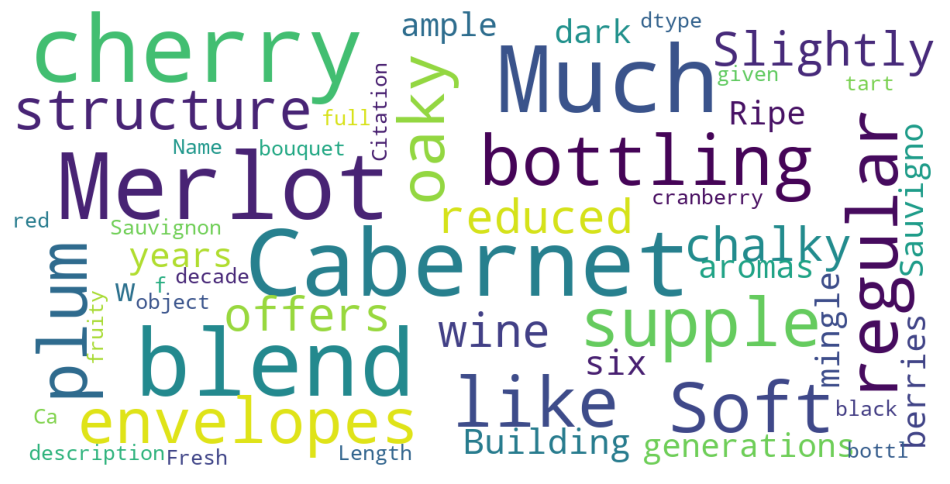

In [16]:
#show wordcloud
show_wordcloud(df_top_5['description'])

### mmm, some are relavent for sure, such as 'wine', 'vineyard', but some clearly aren't, such as: 'two', 'months'. We will do some pre-processing to the data to make it better.  

### 
- So, the thing is, neural netwroks, or machine learning models can't work on textual data. As a result, we can't just pass text data to the model. What we can do is, find a way to convert the text data to numerical data, and feed it to the model. 
- Special characters, such as: '@#%*&' don't impact the decision process, as they are quiet arbitray, so we can get rid of them from the 'description'
- 'He is a good man', 'He is a bad man'. In these two sentences, words such as: 'he', 'is', 'a', 'man' don't make any difference wheather the person is this or that. There are called stop words, and we want to get rid of them. This will save us a lot of memory and computation. 
- 'He' and 'he' are same words, we know, but a computer doesn't know that. So, instead of considering them to be two different words, we we convert all the words in their lowercasr forms. This is save us memory and computation without impacting the result.
- We will get all the words in their base form. For example: instead of considering 'go' and 'went' to be two different words, we will convert 'went' into 'go'.
- And finally, we will encode the classes as numbers. 



In [17]:
#preprocessing
def preprocess_text(df):
    #remove special characters
    df['description'] = df['description'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))
    #convert to lowercase
    df['description'] = df['description'].apply(lambda x: x.lower())
    #remove stopwords
    stop_words = stopwords.words('english')
    df['description'] = df['description'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
    #lemmatization
    lemmatizer = WordNetLemmatizer()
    df['description'] = df['description'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
    #encode the labels
    df['variety'] = df['variety'].factorize()[0]
    return df

In [53]:
df_top_5_processed = preprocess_text(df_top_5)

In [36]:
#show wordcloud
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords.words('english'),
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [ ]:
mask = np.array(Image.open("/kaggle/input/winemask/wine_mask.png"))
transformed_mask = np.ndarray((mask.shape[0],mask.shape[1]), np.int32)
transformed_mask[mask == 0] = 255
#::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
#:: Creating the word cloud, and plotting it to console.        :::
#::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

## creating the word cloud object. ##
wordcloud = WordCloud(stopwords=newlist,max_words=100,background_color='white', mask=transformed_mask, contour_width=3).generate(text)

## plotting the word cloud object. ##
plt.figure(figsize=[30,20])
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.show()

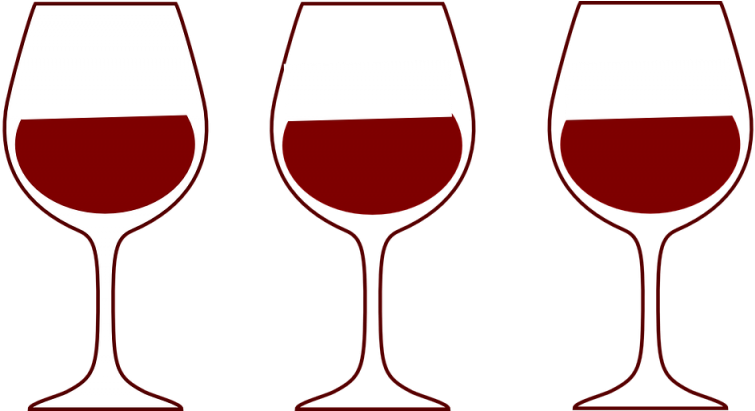

In [56]:
bowie_image

### Now, let's have a look at the wordcloud again, and see if it's improved

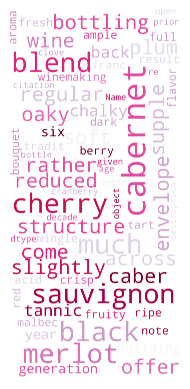

<Figure size 640x480 with 0 Axes>

In [66]:
#show wordcloud
# show_wordcloud(df_top_5_processed['description'])
from PIL import Image
bowie_image = Image.open("/Users/juan/Documents/Juan's MacBook Pro/CUNEF/Quinto/ETL/Practica Final/Plots/wineglass4.png")

bowie_mask = np.array(bowie_image)

colors = ImageColorGenerator(bowie_mask)

from wordcloud import WordCloud, ImageColorGenerator


wordcloud = WordCloud(scale=3,
                      max_words=150,
                      colormap='PuRd',
                      mask=bowie_mask,
                      background_color='white',
#                       stopwords=stopwords,
                      collocations=False)
image_colors = ImageColorGenerator(bowie_mask)
wordcloud.generate(str(df_top_5_processed['description']))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
plt.savefig('wine_cloud.png')

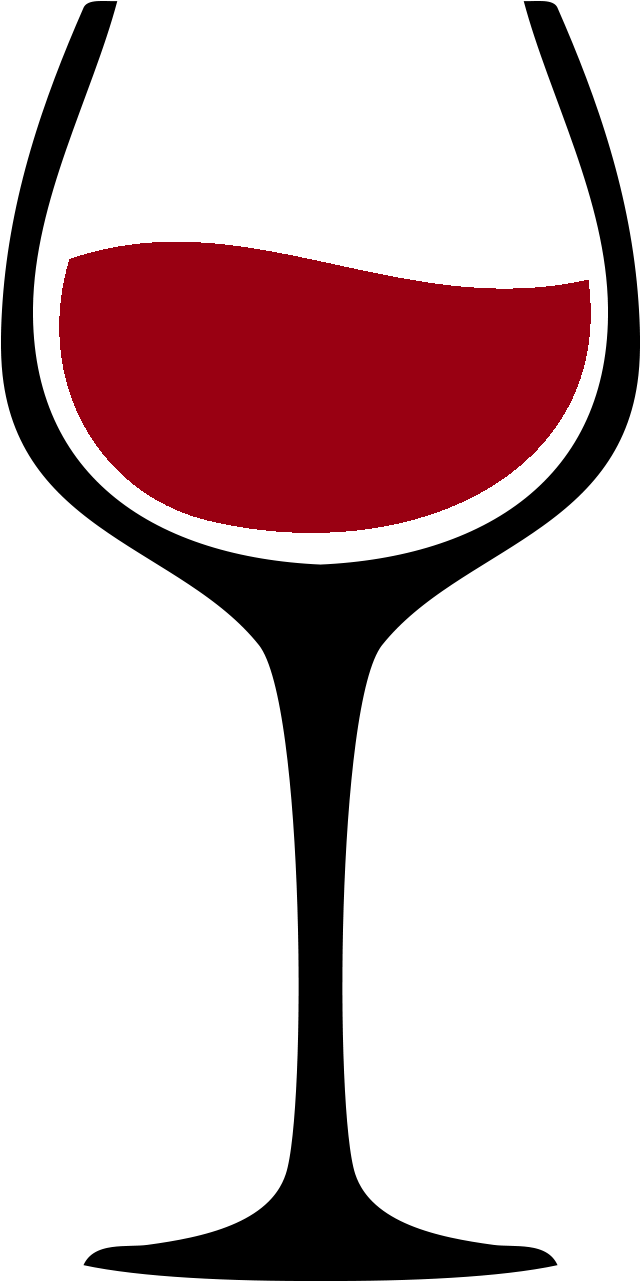

In [35]:
bowie_image

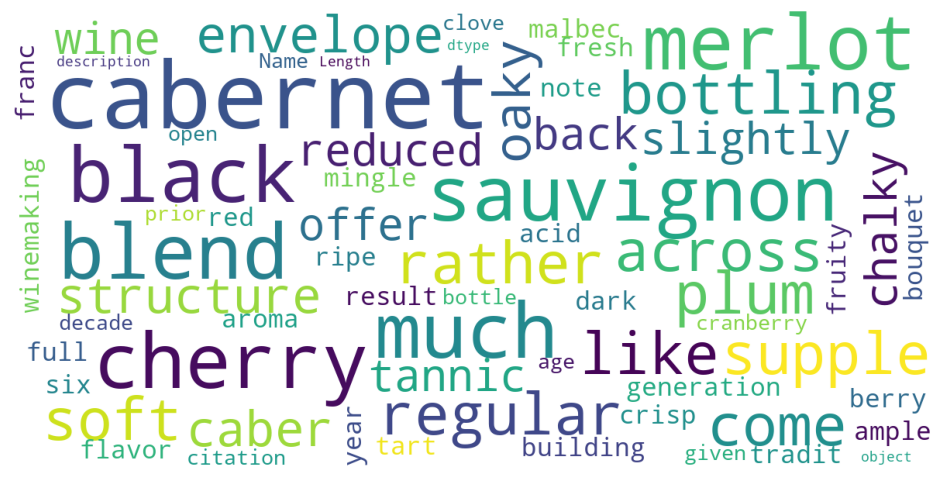

In [37]:
show_wordcloud(df_top_5_processed['description'])

# 2. Split the data, and prepare it for the training and testing

In [20]:
#split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(df_top_5_processed['description'], df_top_5_processed['variety'], test_size=0.2, random_state=42)

In [21]:
#check how many unique words we have
vocab_size = len(set(' '.join(X_train).split()))
print('Vocab size: ', vocab_size)

Vocab size:  18109


### There are some 20395 unique words in the whole training sample. We need to provide the number of words in our corpus, so that it can encode them with numbers. 

In [22]:
#vocab size
vocab_size = 10000 
encoded_docs_train = [one_hot(d, vocab_size) for d in X_train]
encoded_docs_test = [one_hot(d, vocab_size) for d in X_test]

### All the descriptions are not of same length for sure. So, we pad the shorter descriptions. 

In [23]:
#pad the sequences
max_length = 100
padded_docs_train = pad_sequences(encoded_docs_train, maxlen=max_length, padding='post')
padded_docs_test = pad_sequences(encoded_docs_test, maxlen=max_length, padding='post')

# 3. Model , train, test

### Model

In [24]:
#max length
max_length = 100
#embedding size
embedding_size = 32
#number of classes
num_classes = 5
#model
model = Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_length))
#bidirectional LSTM
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           320000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 5)                 325       
                                                                 
Total params: 336,965
Trainable params: 336,965
Non-trainable params: 0
_________________________________________________________________


### Train

In [25]:
#train the model
model.fit(padded_docs_train, y_train, epochs=10, verbose=1, )

Epoch 1/10
2518/2518 [==============================] - 175s 68ms/step - loss: 0.5165 - accuracy: 0.8123
Epoch 2/10
2518/2518 [==============================] - 209s 83ms/step - loss: 0.2848 - accuracy: 0.9043
Epoch 3/10
2518/2518 [==============================] - 163s 65ms/step - loss: 0.2277 - accuracy: 0.9242
Epoch 4/10
2518/2518 [==============================] - 158s 63ms/step - loss: 0.1873 - accuracy: 0.9381
Epoch 5/10
2518/2518 [==============================] - 170s 67ms/step - loss: 0.1560 - accuracy: 0.9489
Epoch 6/10
2518/2518 [==============================] - 174s 69ms/step - loss: 0.1333 - accuracy: 0.9563
Epoch 7/10
2518/2518 [==============================] - 178s 71ms/step - loss: 0.1121 - accuracy: 0.9637
Epoch 8/10
2518/2518 [==============================] - 167s 66ms/step - loss: 0.0975 - accuracy: 0.9679
Epoch 9/10
2518/2518 [==============================] - 171s 68ms/step - loss: 0.0838 - accuracy: 0.9735
Epoch 10/10
2518/2518 [==============================] 

### Test

In [26]:
#evaluate the model
loss, accuracy = model.evaluate(padded_docs_test, y_test, verbose=1)
print('Accuracy: %f' % (accuracy*100))

630/630 [==============================] - 12s 15ms/step - loss: 0.2059 - accuracy: 0.9493
Accuracy: 94.931495
